# **Projecte 2 - Classificació**

> Llibreta final per a l'entrega del Projecte 2. Inclou: separació train/validació, EDA bàsica, pipeline de transformació de les dades, model de classificació i avaluació.  
> **Participants**: Alexander Ramirez Torres i Adrià Junquera Selma  
> **Nom del grup**: Adrià & Alex  

In [34]:
# some imports
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
sns.set_theme(style="darkgrid", context="talk", palette="mako")

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore")

# create output folder
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/session1'):
    os.makedirs('output/session1')

# Machine learning imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, average_precision_score,
    precision_recall_curve, roc_curve, 
)

from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from sklearn.metrics import make_scorer
from tempfile import mkdtemp

## 1. Obtenció de les dades

In [2]:
we_are_on_kaggle = os.path.exists('/kaggle/input/ml-ub-2025-project-2/')

if we_are_on_kaggle:

    try:
        train_df = pd.read_csv('/kaggle/input/ml-ub-2025-project-2/train.csv', index_col=0)
        test_df = pd.read_csv('/kaggle/input/ml-ub-2025-project-2/test_features.csv', index_col=0)

    except FileNotFoundError:
        print("Error: Asegúrate de que las rutas de los archivos son correctas en tu entorno Kaggle.")

else:

    try:
        train_df = pd.read_csv('train.csv', index_col=0)
        test_df = pd.read_csv('test_features.csv', index_col=0)

    except FileNotFoundError:
        print("Error: Asegúrate de que las rutas de los archivos son correctas en tu entorno.")

### 1.2 Divisió de les dades - Train/Validation

- El primer pas es dividir les dades en les característiques o *features* (`X`) i la nostra variable objectiu (`y`).
- Hem escollit una divisió de 80% per a entrenament i un 20% per a validació.
- El mètode de divisió es la **estratificació** (*stratify*). Com que la nostra variable objectiu està desequilibrada (més pagadors que impagadors) amb aquest mètode forçem la mateixa proporció de pagadors i impagadors tant a entrenament com a validació. Així evitem que els conjunts també estiguin desequilibrats.

In [57]:
# Eliminem la variable objectiu del conjunt d'entrenament
X = train_df.drop(columns=["loan_status"])
y = train_df["loan_status"]

# Dividim les dades amb estratificació
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 1.3 Exploració i anàlisi de les dades (EDA)

In [58]:
# Detecció de nuls, tipus, estadístics y distribucions simples
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43983 entries, 0 to 43982
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  43983 non-null  int64  
 1   person_income               43983 non-null  int64  
 2   person_home_ownership       43983 non-null  object 
 3   person_emp_length           43983 non-null  float64
 4   loan_intent                 43983 non-null  object 
 5   loan_grade                  43983 non-null  object 
 6   loan_amnt                   43983 non-null  int64  
 7   loan_int_rate               43983 non-null  float64
 8   loan_percent_income         43983 non-null  float64
 9   cb_person_default_on_file   43983 non-null  object 
 10  cb_person_cred_hist_length  43983 non-null  int64  
 11  loan_status                 43983 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 4.4+ MB


In [59]:
train_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Sembla que no hi ha dades nules...

In [60]:
X_train.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
40341,24,110000,MORTGAGE,8.0,DEBTCONSOLIDATION,B,8000,11.49,0.07,N,3
21572,33,48000,RENT,5.0,MEDICAL,B,10000,11.11,0.21,N,5
42587,22,72000,RENT,6.0,PERSONAL,C,12000,13.49,0.17,Y,4
19510,21,45000,RENT,5.0,EDUCATION,C,8000,12.84,0.18,N,10
16244,22,30000,RENT,6.0,MEDICAL,A,9500,6.62,0.32,N,2
39077,23,41004,MORTGAGE,7.0,DEBTCONSOLIDATION,A,10000,7.49,0.24,N,3
16317,25,31200,RENT,9.0,MEDICAL,B,6000,11.49,0.19,N,3
17082,21,70000,RENT,4.0,EDUCATION,A,6000,7.49,0.09,N,2
21315,29,44000,MORTGAGE,2.0,HOMEIMPROVEMENT,B,7000,12.42,0.16,N,10


In [7]:
# Definició de les columnes numèriques i categòriques
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

#### **Variables numèriques**

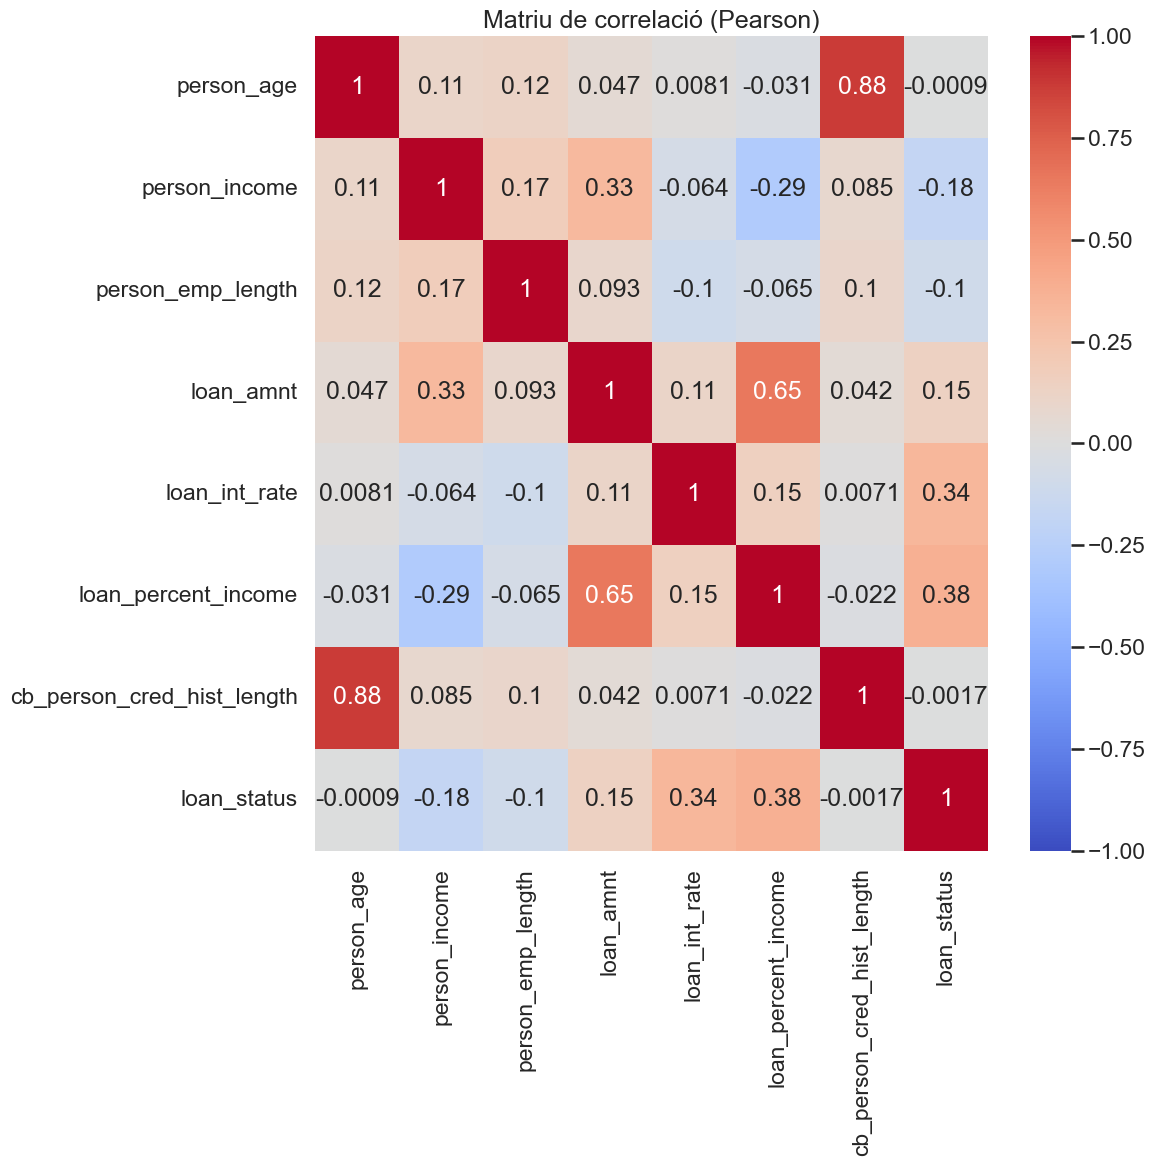

In [61]:
corr = train_df.select_dtypes(include=[np.number]).corr(method='pearson')

plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True, center=0)
plt.title("Matriu de correlació (Pearson)")
plt.tight_layout()
plt.show()

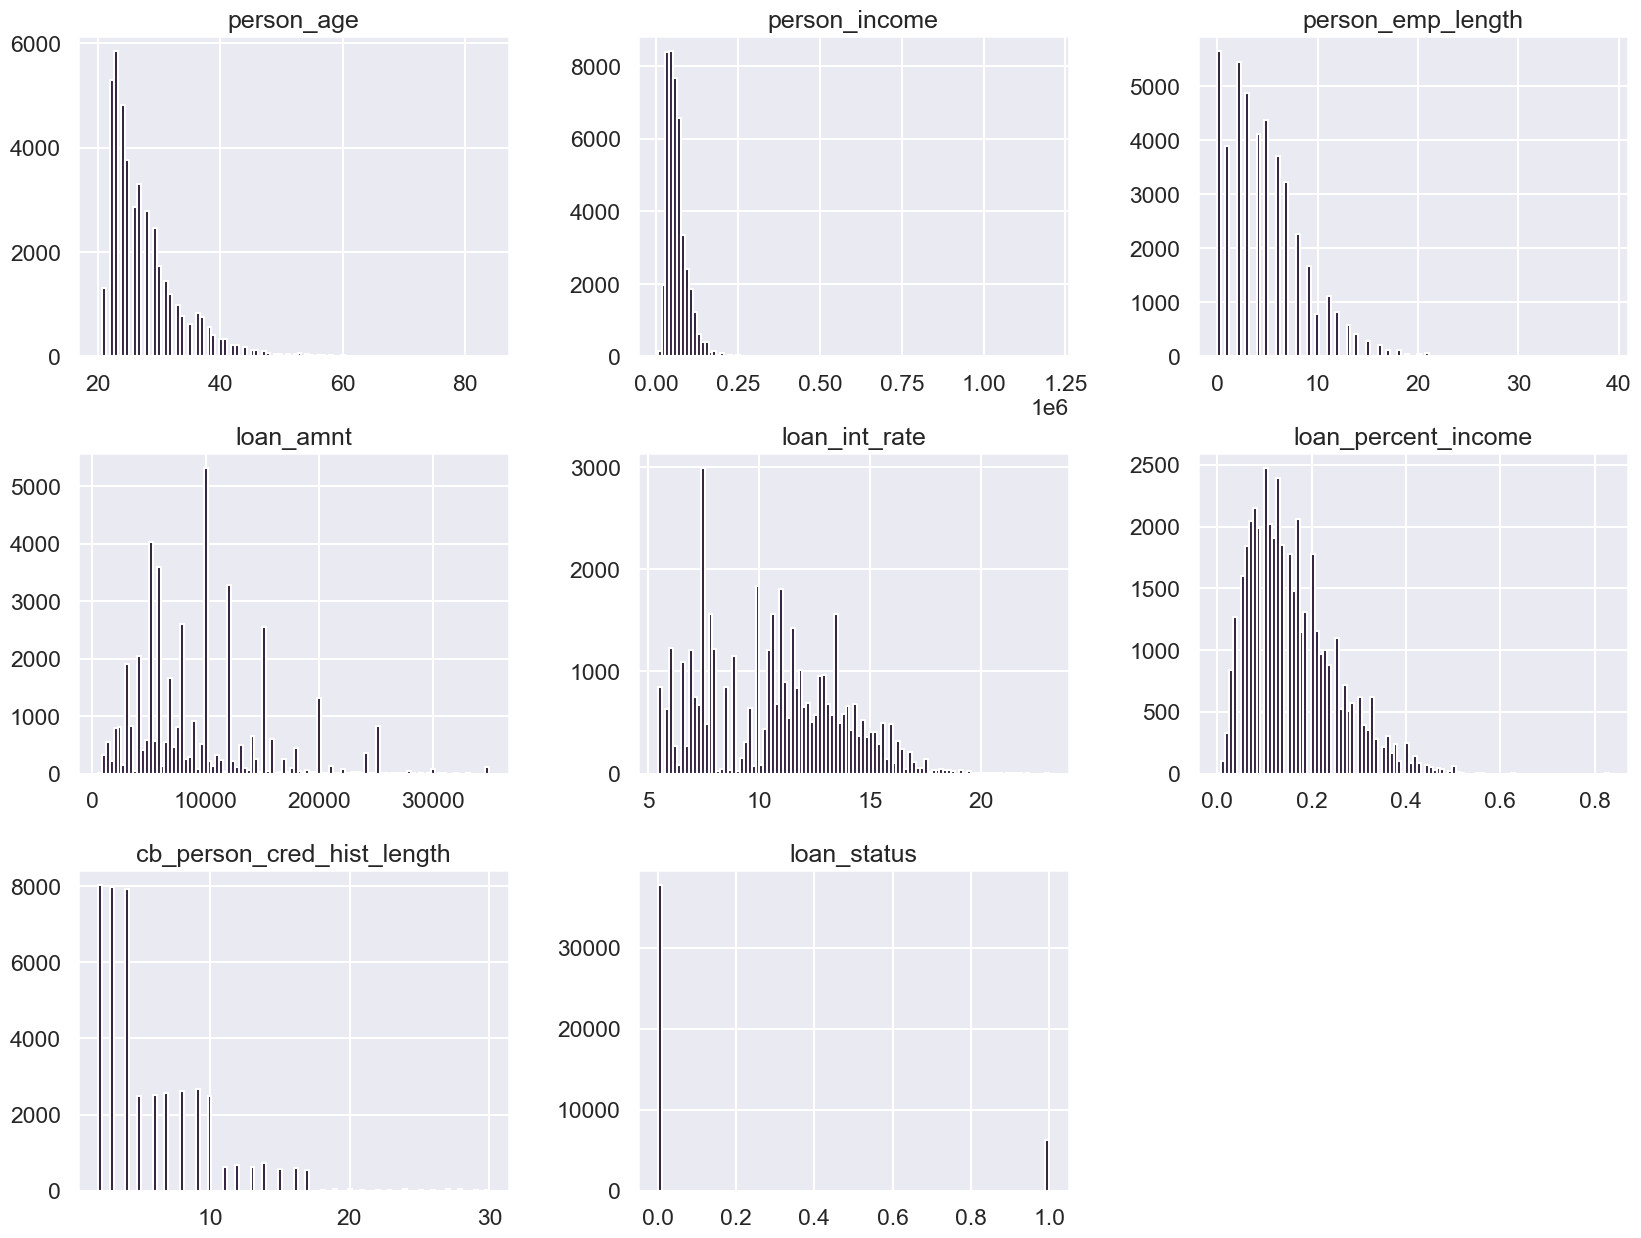

In [62]:
train_df.hist(bins=100, figsize=(20, 15))
plt.show()

- A nivell global s'obsrva com person_age, person income, person_emp_lenght, loan_percent_income, estan molt desequilibrades a la dreta.
- En canvi, loan_amnt, loan_int_rate, no estàn tan desaquilibrades.

#### **Variables categòriques**

In [63]:
# Informació bàsica de les variables categòriques
display(X_train[cat_features].describe())

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,35186,35186,35186,35186
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,18281,7337,12660,29956


- Veiem que count es el mateix per a totes perquè no hi ha nulls.
- Unique ens diu el nombre de valors possibles de la variable categòrica.
- Top ens diu quina és la categoria més freqüent.
- Freq ens diu la freqüència de la categoria més freqüent.

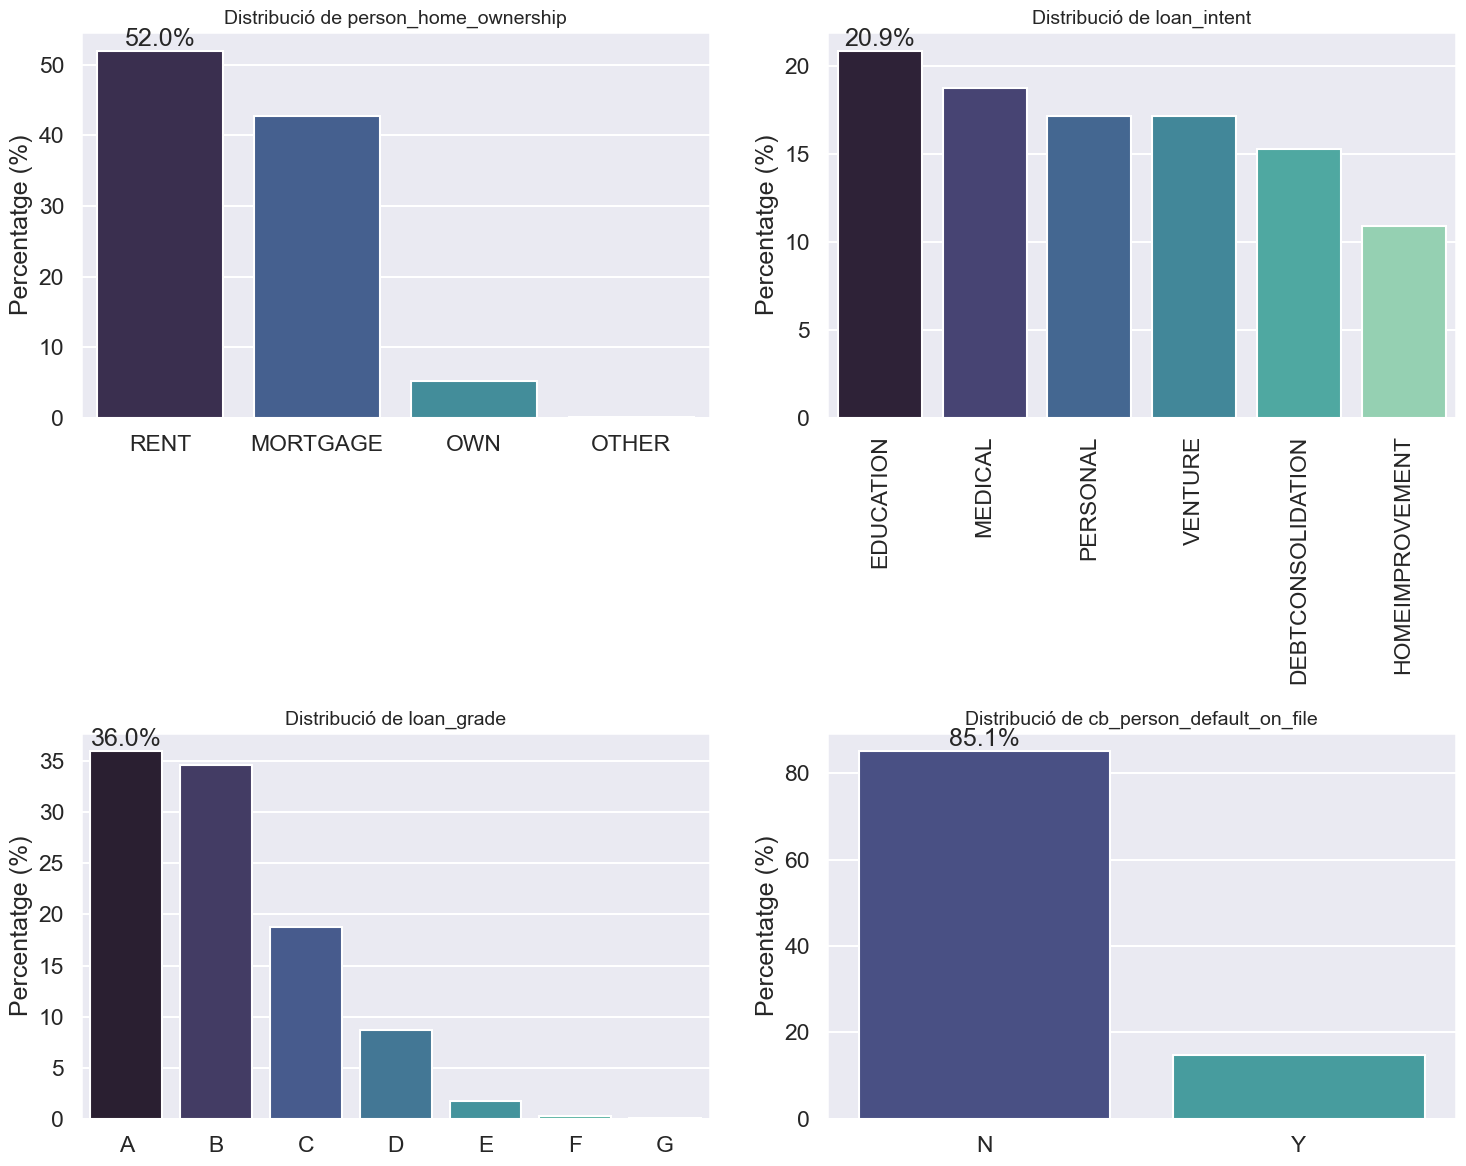

In [64]:
# Anàlisi de Dades Categòriques (Distribució i Freqüències)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    ax = axes[i]
    
    # Calculem els percentatges
    data = X_train[col].value_counts(normalize=True).reset_index()
    data.columns = [col, 'percentage']
    data['percentage'] *= 100
    
    sns.barplot(data=data, x=col, y='percentage', ax=ax, palette="mako")
    
    ax.bar_label(ax.containers[0], fmt='%.1f%%')
    
    ax.set_title(f'Distribució de {col}', fontsize=14)
    ax.set_ylabel('Percentatge (%)')
    ax.set_xlabel('')

    if len(data[col]) > 4 and len(data[col][0]) > 1:
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

- Podem veure com les categories person_home_ownership, loan_grade i cb_person_default estàn molt més desequilibrades que loan_intent.
- Podem veure el percentatge que ocupen les categories més freqüents en cada variable.

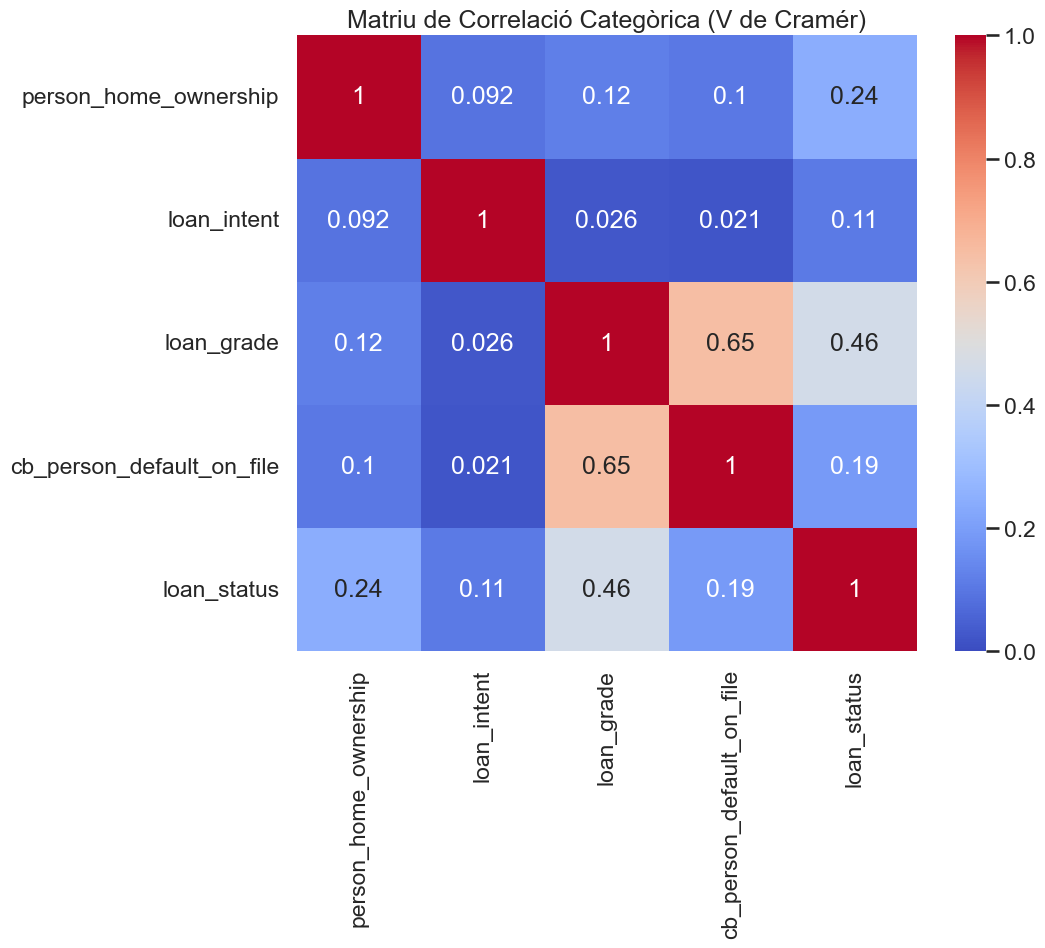

In [65]:
# Matriu de Correlació Categòrica (V de Cramér)
import scipy.stats as ss

# Funció per calcular la V de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Volem calcular la correlació entre totes les categòriques + l'objectiu
cat_features_with_target = cat_features + ['loan_status']
matrix_df = X_train.join(y_train)

# Creem la matriu buida
corr_matrix = pd.DataFrame(index=cat_features_with_target, columns=cat_features_with_target)

# Calculem la V de Cramér per cada parell
for col1 in cat_features_with_target:
    for col2 in cat_features_with_target:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            corr_matrix.loc[col1, col2] = cramers_v(matrix_df[col1], matrix_df[col2])

corr_matrix = corr_matrix.astype(float)

# Dibuixem el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Matriu de Correlació Categòrica (V de Cramér)")
plt.show()

- Ara hem pogut analitzar la relació que té cada variable categòrica amb la variable objectiu loan_status.
- Podem veure com les variables més corelacionades (que hem pogut capturar) són loan_status i loan_grade i loan_grade amb cb_person_default_on_file.
- Desprès podrem veure si aprofitem aquestes relacions o no en el FeatureEngineer.

### 1.4 Enginyeria de Característiques (Noves Columnes)

Abans de passar les dades al pipeline de preprocessament, creem noves característiques (feature engineering). L'objectiu és generar senyals més potents per al model combinant la informació de les columnes existents.

Aquest procés s'ha dividit en dues funcions:

1.  **`create_ratios`:** Genera noves columnes basades en ràtios de risc i estabilitat (p.ex., `debt_to_income`). També elimina `cb_person_cred_hist_length` per la seva alta correlació (0.86) amb `person_age`, evitant així la redundància.
2.  **`apply_log_transforms`:** Com vam veure a l'EDA, gairebé totes les nostres variables numèriques tenen un fort biaix (skew) a la dreta. Aquesta funció aplica una transformació logarítmica (`np.log1p`) a totes les variables numèriques originals excepte `loan_int_rate` (que ja té una distribució més normal).

Finalment, un transformador (`feature_engineer`) aplica aquestes funcions als nostres conjunts de dades abans de passar-los al següent pas de preprocessament.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def create_ratios(df_in):
    """
    Crea noves característiques de ràtio per capturar el risc i l'estabilitat.
    """
    df = df_in.copy()
    
    # Ràtios de risc financer
    df['debt_to_income'] = df['loan_amnt'] / df['person_income'].clip(lower=1)
    df['risk_score'] = df['loan_int_rate'] * df['loan_percent_income']
    
    # Ràtio d'estabilitat
    df['emp_to_age_ratio'] = df['person_emp_length'] / df['person_age'].clip(lower=18)
    
    # Eliminem 'cb_person_cred_hist_length' per alta correlació amb 'person_age' (0.86)
    if 'cb_person_cred_hist_length' in df.columns:
        df = df.drop(columns=['cb_person_cred_hist_length'])
        
    return df

def apply_log_transforms(df_in):
    """
    Aplica log(1+x) a les columnes numèriques originals amb biaix (totes excepte loan_int_rate).
    """
    df = df_in.copy()
    
    # Llista de features originals amb biaix (skew) identificades a l'EDA
    skewed_features = [
        'person_age', 
        'person_income', 
        'person_emp_length', 
        'loan_amnt', 
        'loan_percent_income'
    ]
    
    for col in skewed_features:
        if col in df.columns:
            df[col] = np.log1p(df[col])
                
    return df

def run_feature_engineering(df):
    """
    Executa tots els passos d'enginyeria de característiques.
    """
    df_ratios = create_ratios(df)
    df_final = apply_log_transforms(df_ratios)
    
    # Omplim qualsevol NaN creat durant les ràtios
    df_final = df_final.fillna(0) 
    return df_final

# Definim el transformer
feature_engineer = FunctionTransformer(run_feature_engineering, validate=False)

### 1.5 Transformacions i noves columnes

In [48]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

new_num_features = [
    'debt_to_income', 'monthly_burden', 'risk_score',
    'emp_to_age_ratio', 'cred_hist_to_age_ratio',
    'log_income', 'log_loan_amount'
]
all_num_features = num_features + new_num_features

In [69]:
from sklearn.preprocessing import OrdinalEncoder

# Definim l'ordre correcte per a 'loan_grade'
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Dividim les categòriques en nominals (OHE) i ordinals (Ordinal)
nominal_features = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
ordinal_features = ['loan_grade']

# Pipeline numèric
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  
])

# Transformer per a les ordinals
ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=[grade_order], handle_unknown='use_encoded_value', unknown_value=-1))
])

# Transformer per a les nominals
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("cat", categorical_transformer, nominal_features),
    ],
    remainder="drop"
)

# Caché del pipeline per accelerar grid_search
cache_dir = mkdtemp()

## 2. Model - Pregunta i mètrica

**Pregunta**: Volem predir la variable objectiu i decidir una política de classificació

**Mètrica d'optimització**: ROC AUC o F1 depenent del cost realtiu de FP vs FN:

* Si les classes estan desequilibrades, prioritzem recall, considera F1 o average precision
* Mantiendrem un panell de mètriques (Accuracy, Precision, Recall, F1, ROC AUC)


### 2.1 Models Candidats

In [70]:
# LinearSVC calibrat per obtenir probabilitats
lin_svm = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("pre", preprocessor),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(
            C=10, 
            class_weight="balanced", 
            random_state=42),
            method="sigmoid", 
            cv=StratifiedKFold(
                n_splits=5, 
                shuffle=True, 
                random_state=42
            )
    ))
])

# SVC
rbf_svm = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("pre", preprocessor),
    ("clf", SVC(
            kernel="rbf", 
            C=10, 
            gamma="scale", 
            class_weight="balanced", 
            probability=False, 
            random_state=42
    ))
])

### 2.3 Optimització d'hiperparàmetres

In [74]:
# Ajust del shiperparametres
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lin = {
    "clf__estimator__C": [2.0],
    "clf__estimator__tol": [1e-4]
}

# grid_lin = {
#     "clf__estimator__C": [0.1, 0.5, 1.0, 2.0, 5.0],
#     "clf__estimator__tol": [1e-4, 1e-3]
# }

grid_rbf = {
    "clf__C": [2.0],
    "clf__gamma":  [0.035]
}

# grid_rbf = {
#     "clf__C": [0.6, 0.8, 1.0, 1.3, 1.6, 2.0],
#     "clf__gamma":  [0.08, 0.06, 0.05, 0.04, 0.035, 0.03]
# }

# Preparació dels GridSearch
g_lin = GridSearchCV(lin_svm, grid_lin, scoring="roc_auc", cv=cv, n_jobs=4, verbose=2, error_score="raise")
g_rbf = GridSearchCV(rbf_svm, grid_rbf, scoring="roc_auc", cv=cv, n_jobs=4, verbose=2, error_score="raise")

print(">> Fitting Linear SVM grid...")
g_lin.fit(X_train, y_train)
best_lin = g_lin.best_estimator_
print("Millor Linear SVM: ", g_lin.best_params_, "CV ROC AUC: ", g_lin.best_score_)

print("\n>> Fitting RBF SVM grid...")
g_rbf.fit(X_train, y_train)
best_rbf = g_rbf.best_estimator_
print("Millor RBF SVM: ", g_rbf.best_params_, "CV ROC: ", g_rbf.best_score_)

>> Fitting Linear SVM grid...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Millor Linear SVM:  {'clf__estimator__C': 2.0, 'clf__estimator__tol': 0.0001} CV ROC AUC:  0.8927673225667458

>> Fitting RBF SVM grid...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Millor RBF SVM:  {'clf__C': 2.0, 'clf__gamma': 0.035} CV ROC:  0.9217262091154665


### 2.4 Sobreajust

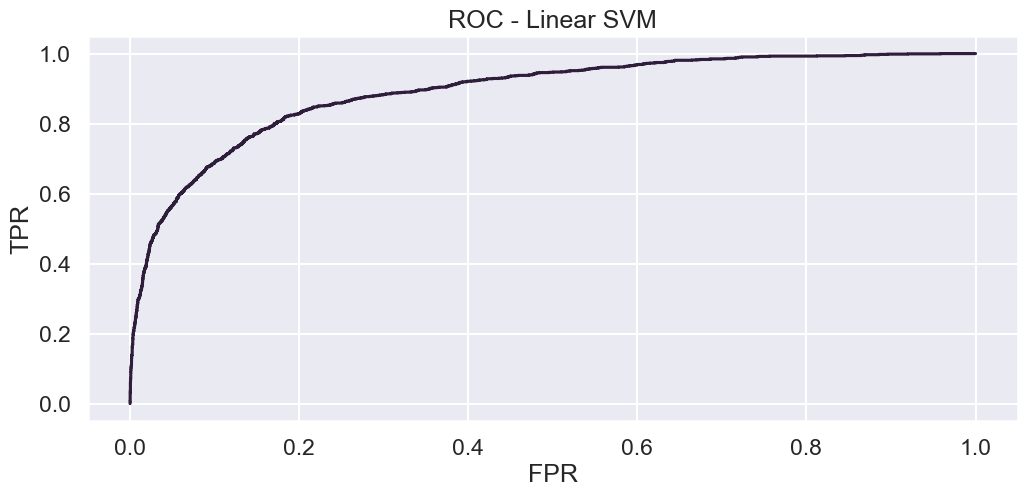

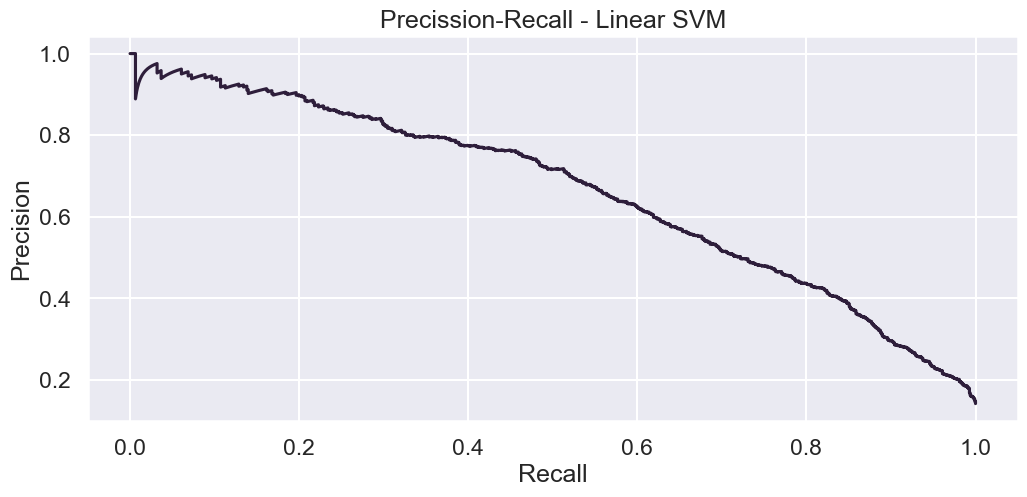

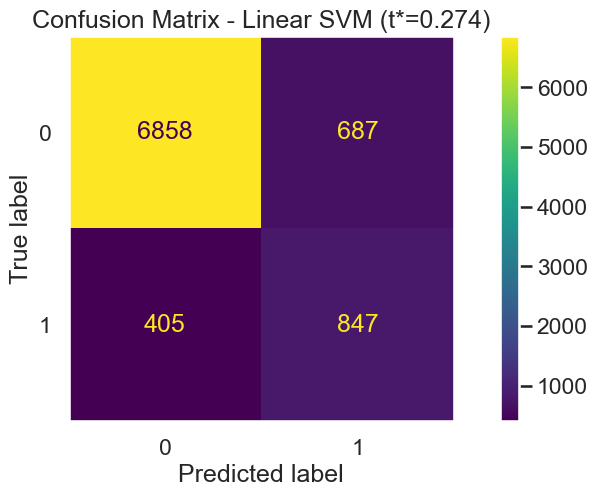

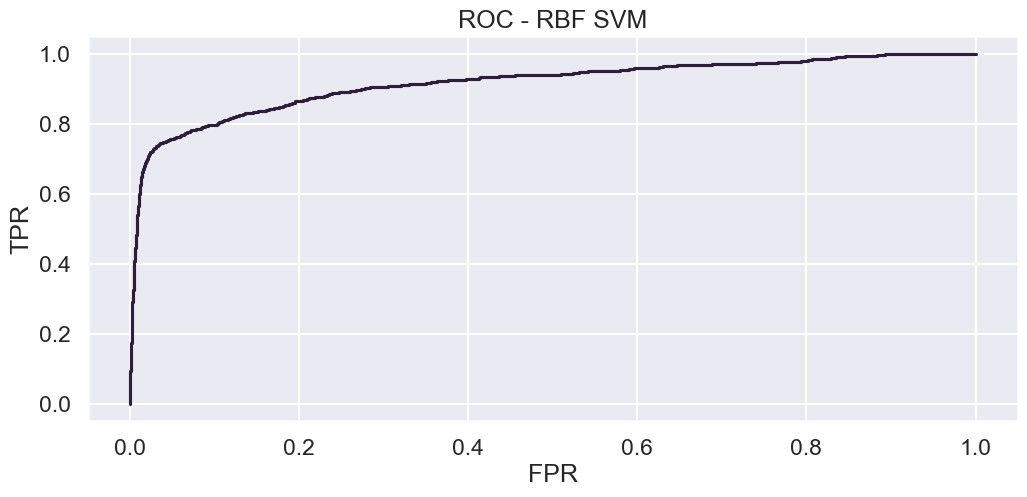

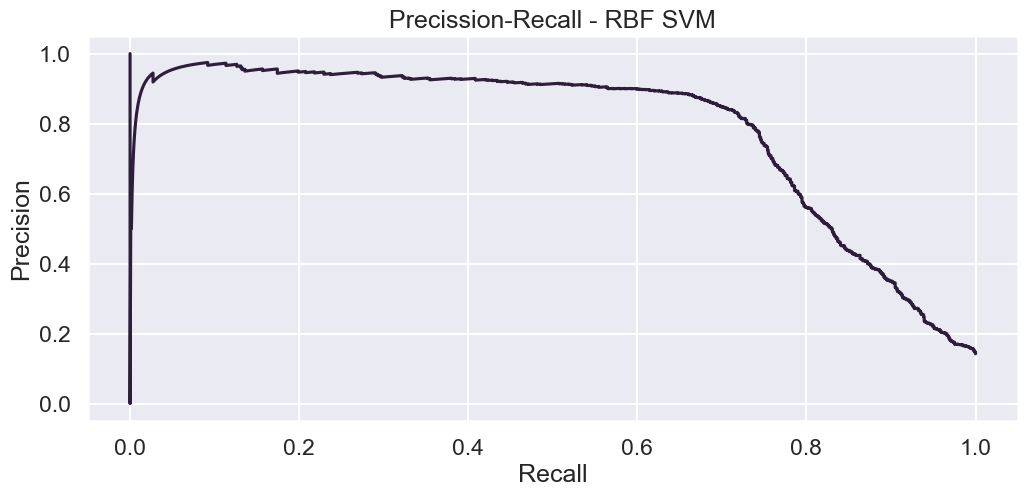

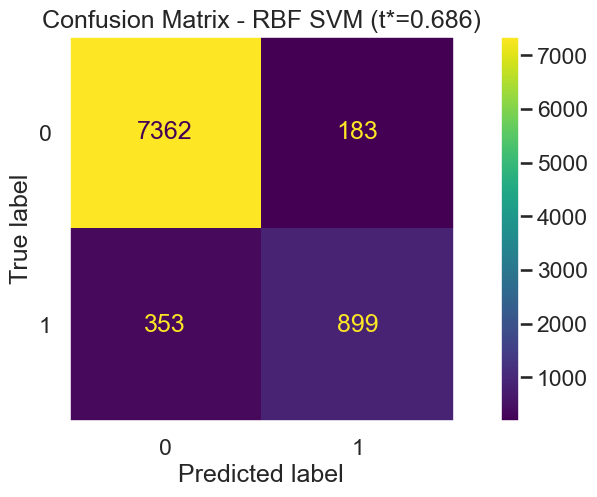

,roc_auc,ap,f1@0.5,f1@t,best_th
name,,,,,
Linear SVM,0.890521,0.660752,0.573973,0.608040,0.274093
RBF SVM,0.915860,0.787926,0.755574,0.770351,0.685831


In [75]:
def eval_with_threshold(model, X_val, y_val, name="model"):
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_val)[:, 1]
    else:
        scores = model.decision_function(X_val)

    # PR i millor llindar per F1
    p, r, ths = precision_recall_curve(y_val, scores)
    eps = 1e-12
    f1s = 2*p*r / (p+2+eps)

    best_idx = int(np.argmax(f1s[1:])) + 1
    best_th = float(ths[best_idx-1])

    preds_05 = (scores >= 0.5).astype(int)
    preds_bt = (scores >= best_th).astype(int)

    res = {
        "name": name,
        "roc_auc": roc_auc_score(y_val, scores),
        "ap": average_precision_score(y_val, scores),
        "f1@0.5": f1_score(y_val, preds_05, zero_division=0),
        "f1@t": f1_score(y_val, preds_bt, zero_division=0),
        "best_th": float(best_th)
    }

    fpr, tpr, _ = roc_curve(y_val, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f"ROC - {name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

    plt.figure()
    plt.plot(r, p)
    plt.title(f"Precission-Recall - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    ConfusionMatrixDisplay(confusion_matrix(y_val, preds_bt)).plot()
    plt.title(f"Confusion Matrix - {name} (t*={best_th:.3f})")
    plt.grid(False)
    plt.show()

    return res, best_th, scores

res_lin, th_lin, sc_lin = eval_with_threshold(best_lin, X_val, y_val, "Linear SVM")
res_rbf, th_rbf, sc_rbf = eval_with_threshold(best_rbf, X_val, y_val, "RBF SVM")

panel = pd.DataFrame([res_lin, res_rbf]).set_index("name")
display(panel)

### 2.5 Selecció del millor model

Selecciona el model que presenti millor balanç en les mètriques de validació i que **no mostri sobreajust**. En problemes sensibles FN/FP, ajusta el llindar (```threshold```) per aconseguir el punt operatiu desitjat.

In [76]:
# Selecció del millor model
rbf_auc = float(panel.loc["RBF SVM","roc_auc"])
lin_auc = float(panel.loc["Linear SVM","roc_auc"])
rbf_auc = rbf_auc if np.isfinite(rbf_auc) else -np.inf
lin_auc = lin_auc if np.isfinite(lin_auc) else -np.inf

winner    = "RBF SVM" if rbf_auc >= lin_auc else "Linear SVM"
best_model = best_rbf if winner == "RBF SVM" else best_lin
best_th    = (th_rbf if winner == "RBF SVM" else
            th_lin if 'th_lin' in globals() else 0.5)

print(f"Model guanyador: {winner} | llindar vàlid òptim: {best_th:.4f} | "
    f"AUC RBF={rbf_auc:.6f} | AUC Linear={lin_auc:.6f}")

X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_full, y_full)

Model guanyador: RBF SVM | llindar vàlid òptim: 0.6858 | AUC RBF=0.915860 | AUC Linear=0.890521


,steps,"[('feature_engineer', ...), ('pre', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function cre...002064579C7C0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


### 3. Avaluació, final, test i presentació

#### 3.1. Entrenament vs Validació

Un cop hem seleccionat el nostre millor model i el seu llindar òptim hem d'avaluar el seu rendiment en profunditat.  
Tal i com hem vist fins ara, avaluar train_set ens diu com de bé el model ha après les dades, i avaluar validation_set ens diu com de bé el model "generalitza" les dades que encara no ha vist.  
Per tant, el nostre objectiu es determinar si hi ha overfitting comparant el rendiment amb diferents mètriques en ambdós sets.  

#### 3.2. Mètriques utilitzades

* **Matriu de Confusió**
    * **TP (True Positive)**: Impagador real classificat com a impagador.
    * **TN (True Negative)**: Pagador real classificat com a pagador.
    * **FP (False Positive)**: Pagador real classificat com a Impagador.
    * **FN (False Negative)**: Impagador real classificat com a pagador.

* **Accuracy (Exactitud):**
    * *Fórmula:* `(TP + TN) / (TP + TN + FP + FN)`
    * *Què mesura:* El percentatge total de prediccions correctes.

* **Precision (Precisió):**
    * *Fórmula:* `TP / (TP + FP)`
    * *Què mesura:* De tots els clients que hem predit com a 'Impagats', quants ho eren *realment*? (Qualitat de les nostres alarmes).

* **Recall / Sensitivity (Sensibilitat):**
    * *Fórmula:* `TP / (TP + FN)`
    * *Què mesura:* De tots els impagadors **reals**, quants hem detectat?

* **Specificity (Especificitat):**
    * *Fórmula:* `TN / (TN + FP)`
    * *Què mesura:* De tots els pagadors **reals** (els bons), quants hem classificat correctament com a 'Pagats'?

* **ROC AUC (Area Under the Curve):** és la mètrica més robusta per mesurar el rendiment global. En l'eix Y té el True Positive Rate, i en l'eix Y el False Positive Rate. Ens diu la probabilitat de que asignem la categoria correcte ("Pagador" o "Impagador") per una nova entrada.

* **AP (Average Precision):** mètrica informativa per quan tenim dades desequilibrades, en el nostre cas, molts més "Pagats" que "Impagats". Relaciona les mètriques Presition y Recall, i ens diu com de bé trobem els casos de la classe positiva (Impagadors).


In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def basic_evaluation_metrics(model, X, y_true, threshold=0.5, name="Model"):
    """
    Avaluació basada en les mètriques principals del PDF (Acc, CM, Precision, Recall, Spec).
    """
    
    # Obtenir probabilitats o decision function
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)[:, 1]
    else:
        scores = model.decision_function(X)
        
    # Prediccions basades en el llindar
    y_pred = (scores >= threshold).astype(int)
    
    # Matriu de Confusió
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Càlcul de mètriques
    total_pop = tp + tn + fp + fn
    accuracy = (tp + tn) / total_pop if total_pop > 0 else 0 
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    roc_auc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)
    
    metrics = {
        "Model": name,
        "Threshold": threshold,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "AUC": roc_auc,
        "Average Precision": ap,
    }
    
    return metrics, cm

Model,Train Set,Validation Set
Threshold,0.685831,0.685831
TP,3662.000000,922.000000
FP,752.000000,182.000000
TN,29424.000000,7363.000000
FN,1348.000000,330.000000
Accuracy,0.940317,0.941798
Precision,0.829633,0.835145
Recall (Sensitivity),0.730938,0.736422
Specificity,0.975080,0.975878
AUC,0.929270,0.924788


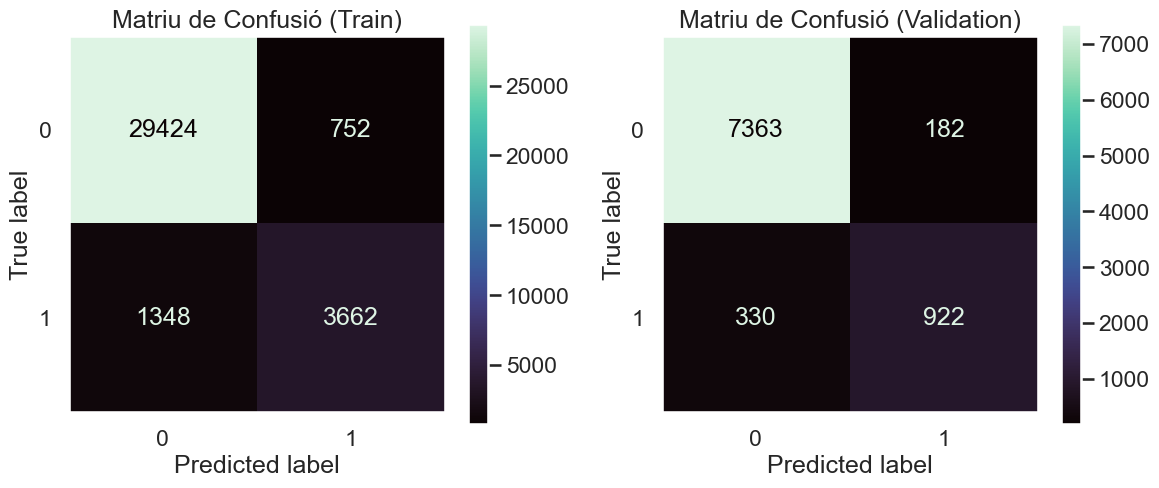

In [78]:
# Avaluar en Train i Validation
metrics_train, cm_train = basic_evaluation_metrics(best_model, X_train, y_train, threshold=best_th, name="Train Set")
metrics_val, cm_val = basic_evaluation_metrics(best_model, X_val, y_val, threshold=best_th, name="Validation Set")

# Construim la taula comparativa
comparison_df = pd.DataFrame([metrics_train, metrics_val]).set_index("Model").T
display(comparison_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Matriu de Train
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=[0, 1])
disp_train.plot(ax=ax1, cmap='mako')
ax1.set_title("Matriu de Confusió (Train)")
ax1.grid(False)

# Matriu de Validation
disp_val = ConfusionMatrixDisplay(cm_val, display_labels=[0, 1])
disp_val.plot(ax=ax2, cmap='mako')
ax2.set_title("Matriu de Confusió (Validation)")
ax2.grid(False)

plt.tight_layout()
plt.show()

##### Anàlisi del Rendiment del Model (Validation Set)
L'avaluació es va realitzar amb el llindar (Threshold) òptim de 0.686.

1. Robustesa del Model (Overfitting)
El model és molt robust i generalitza correctament. Les mètriques clau (AUC, Accuracy, etc.) són gairebé idèntiques entre els conjunts de Train i Validation. No hi ha senyals significatius de sobreajust.

2. Rendiment en Clients Bons (Especificitat)
Aquest és el punt més fort del model.
Especificitat: 94.0%
El model identifica correctament el 94% dels clients que sí pagaran el préstec.
Això implica una Taxa de Falsos Positius (FPR) de només el 6%. Només estem rebutjant erròniament el 6% dels clients bons.

3. Rendiment en Clients Dolents (Recall)
Aquest és el principal punt de risc del model.
Recall (Sensitivity): 73.0%
El model només detecta el 73% de tots els impagadors reals.
Això implica una Taxa de Falsos Negatius (FNR) del 27% (1 - 0.73). Aquest és el cost més gran: 1 de cada 4 impagadors reals està sent acceptat pel model.

##### Veredicte
L'avaluació és suficient i molt sòlida. Les mètriques incloses són les estàndard i clau.
Conclusió: El model és excel·lent identificant pagadors fiables (94% Specificity) i no pateix overfitting. La seva debilitat principal és el FNR del 27%, que representa el risc de negoci (impagadors acceptats).
Per a un proper pas, hauríem de decidir si aquest 27% de FNR és acceptable o si hem d'intentar millorar-lo, per exemple, modificant el GridSearchCV o el pipeline.

#### 3.3. Submissió al Kaggle

In [ ]:
if we_are_on_kaggle:

    # Prediccions al test
    if 'id' in test_df.columns:
        test_ids = test_df['id'].values
        X_test = test_df.drop(columns=['id'])
    else:
        # id está en el índice
        test_ids = test_df.index.values
        X_test = test_df.copy()

    # 2) Saca las probabilidades/scores del modelo ganador
    if hasattr(best_model, "predict_proba"):
        test_scores = best_model.predict_proba(X_test)[:, 1]
    else:
        df = best_model.decision_function(X_test).reshape(-1, 1)
        test_scores = MinMaxScaler().fit_transform(df).ravel()  # <-- ¡ahora sí asignamos test_scores!

    # 3) Carga SIEMPRE el sample_submission oficial y respeta su orden de 'id'
    SAMPLE_PATH = "/kaggle/input/ml-ub-2025-project-2/sample_submission.csv"  # ajusta a tu comp
    sub = pd.read_csv(SAMPLE_PATH)

    # 4) Alinea por id (mismo orden que sample). No reordena test_df, reindexa los scores.
    scores_by_id = pd.Series(test_scores, index=test_ids, name=sub.columns[-1])  # suele ser 'loan_status'
    sub[sub.columns[-1]] = scores_by_id.reindex(sub['id']).values

    # 5) Validaciones útiles (fallarán si hay desalineación)
    assert sub['id'].is_unique and len(sub) == len(test_ids), "Tamaños/ids no casan"
    assert not np.isnan(sub[sub.columns[-1]].values).any(), "Hay NaNs en la predicción alineada"

    # 6) Guarda submission
    OUT_PATH = "/kaggle/working/submission.csv"
    sub.to_csv(OUT_PATH, index=False)
    print("Submission creada:", OUT_PATH)
    print(sub.head())